# Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from optuna import create_study, trial


from modeling import *

In [7]:
df = pd.read_csv("../data/featured_train.csv")
df_valid = pd.read_csv("../data/featured_valid.csv")

# Testing models

In [8]:
y_train = df["FINALIZED_LOAN"]
X_train = df.drop(columns="FINALIZED_LOAN")

y_valid = df_valid["FINALIZED_LOAN"]
X_valid = df_valid.drop(columns="FINALIZED_LOAN")

/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/ml/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.wa

KeyboardInterrupt: 

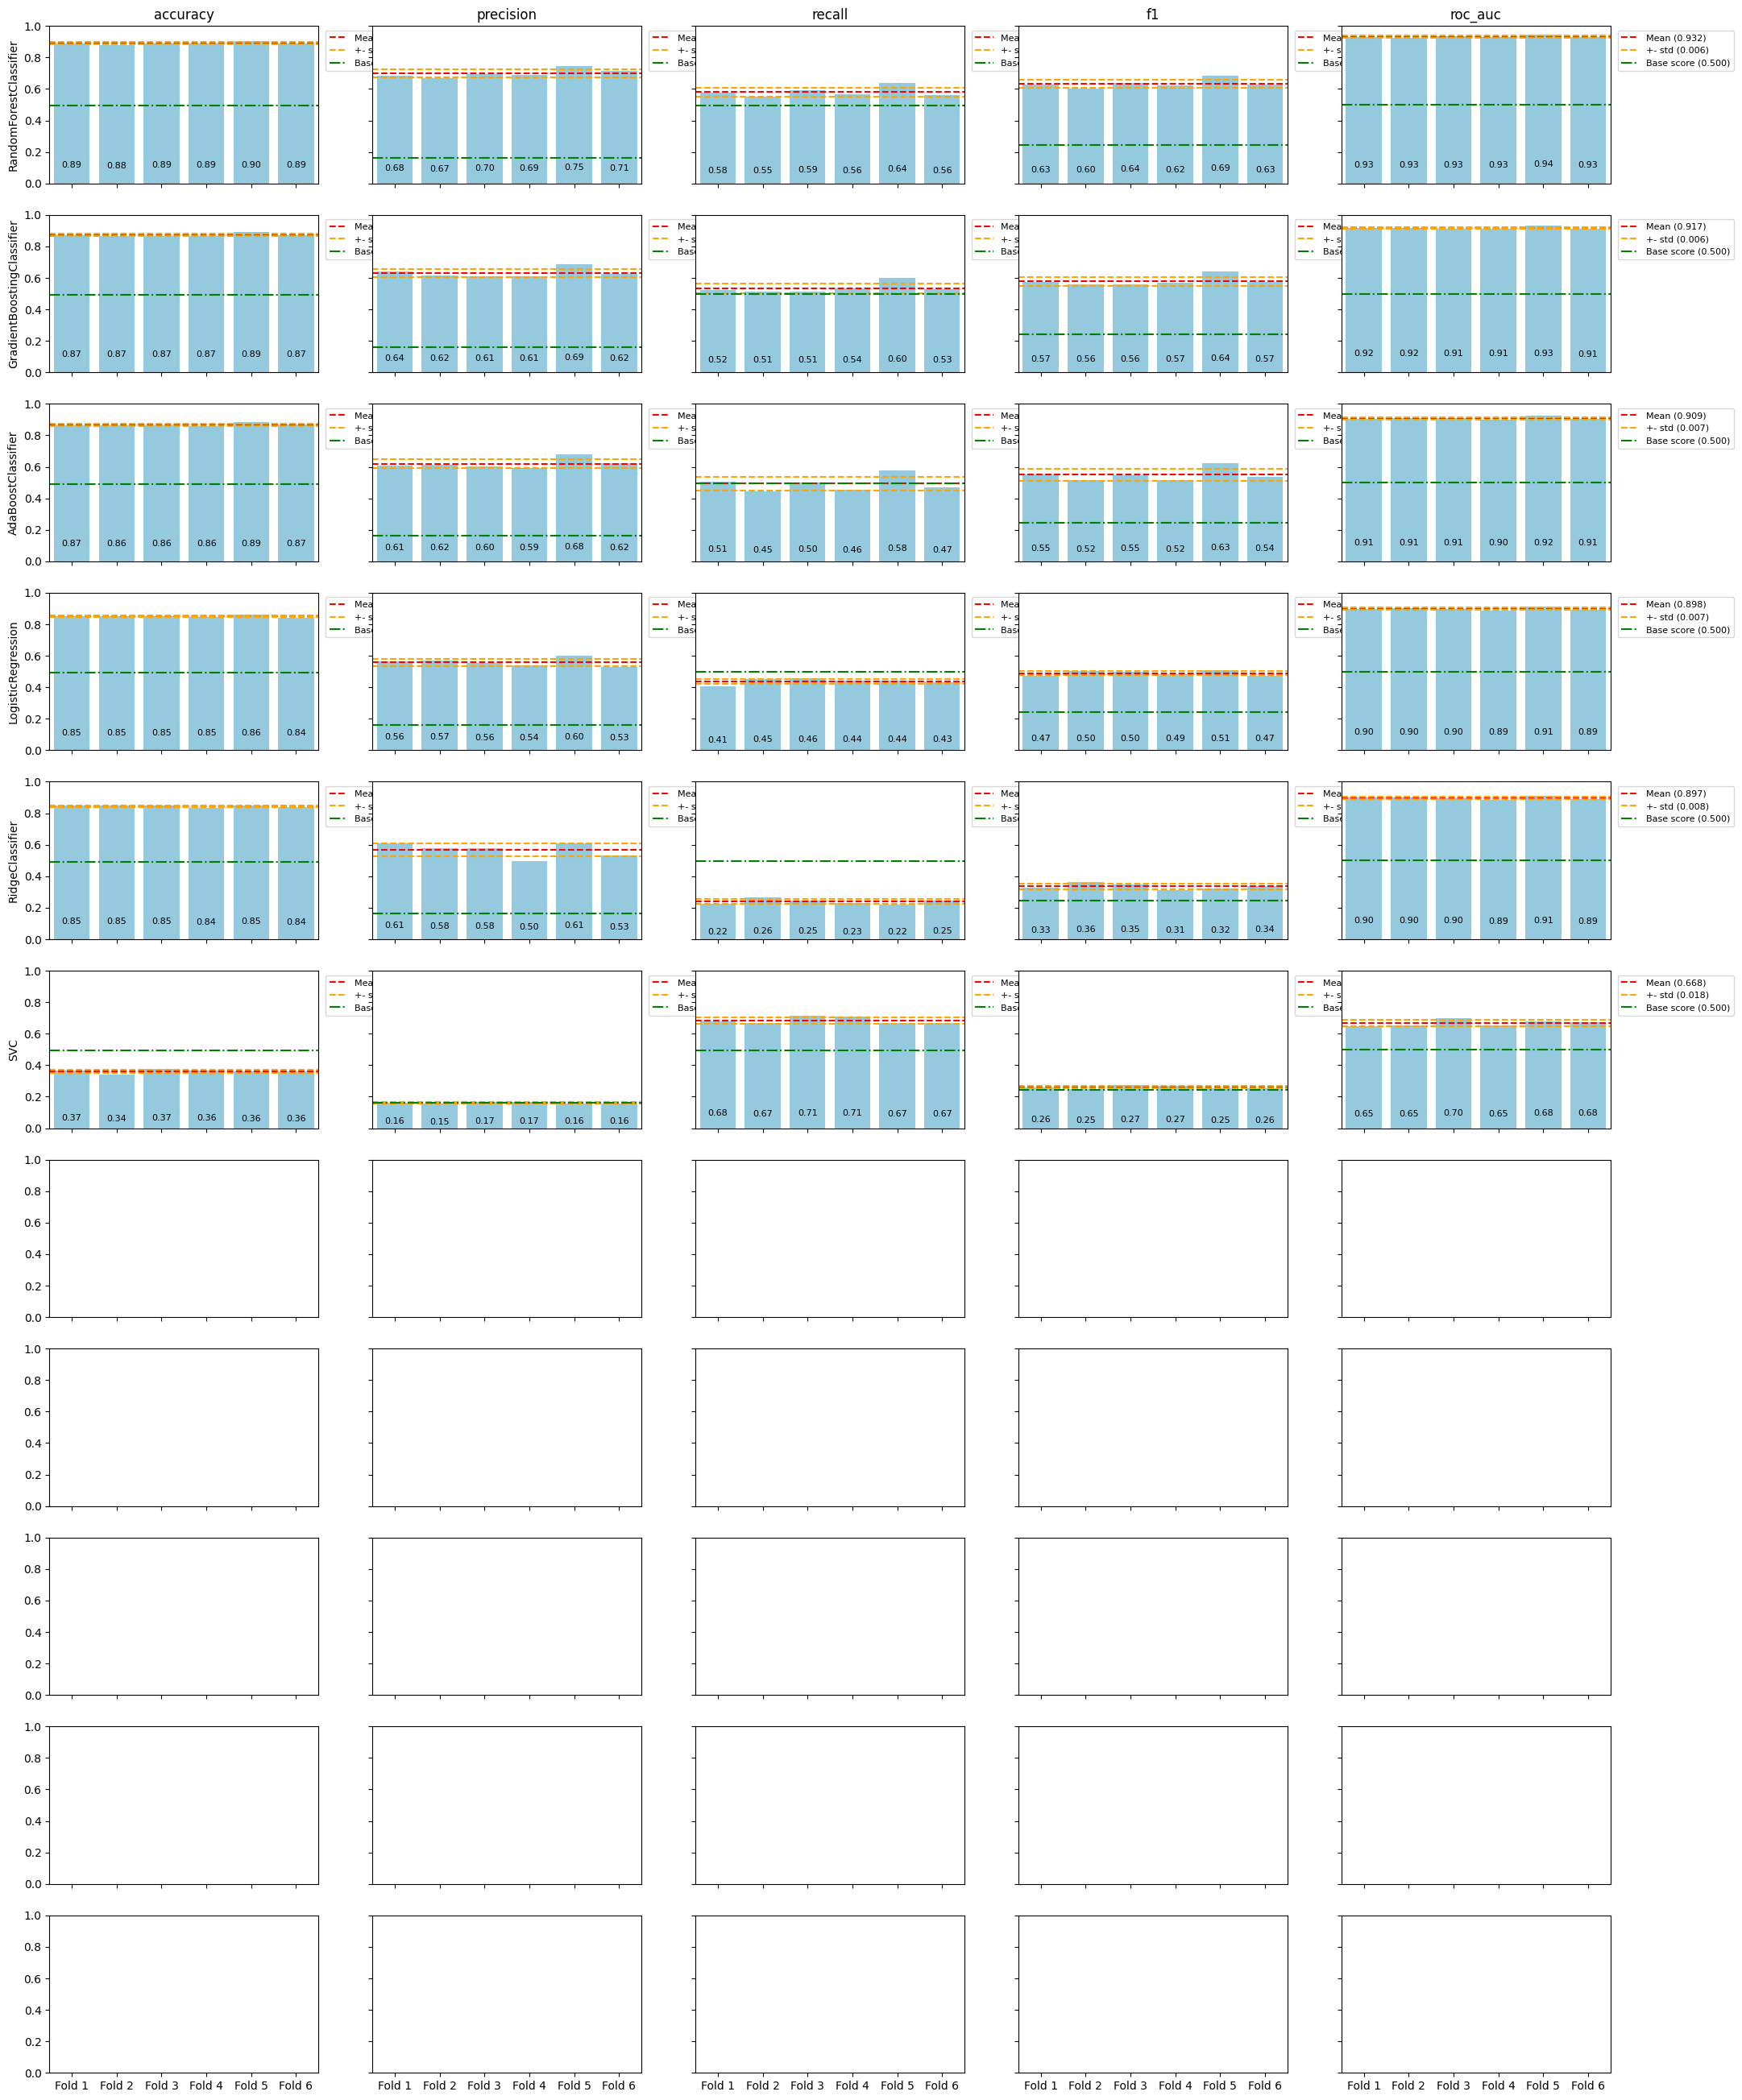

In [4]:
models = [
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    AdaBoostClassifier(algorithm="SAMME"),
    LogisticRegression(max_iter=1000, dual=False),
    RidgeClassifier(),
    SVC(max_iter=1000),
    LinearSVC(dual=False, max_iter=1000),
    KNeighborsClassifier(),
    GaussianNB(),
    MLPClassifier(max_iter=1000),
    XGBClassifier(),
]

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

scores = my_cross_validate(models, X_train, y_train, scoring=scoring)

<Figure size 1200x800 with 0 Axes>

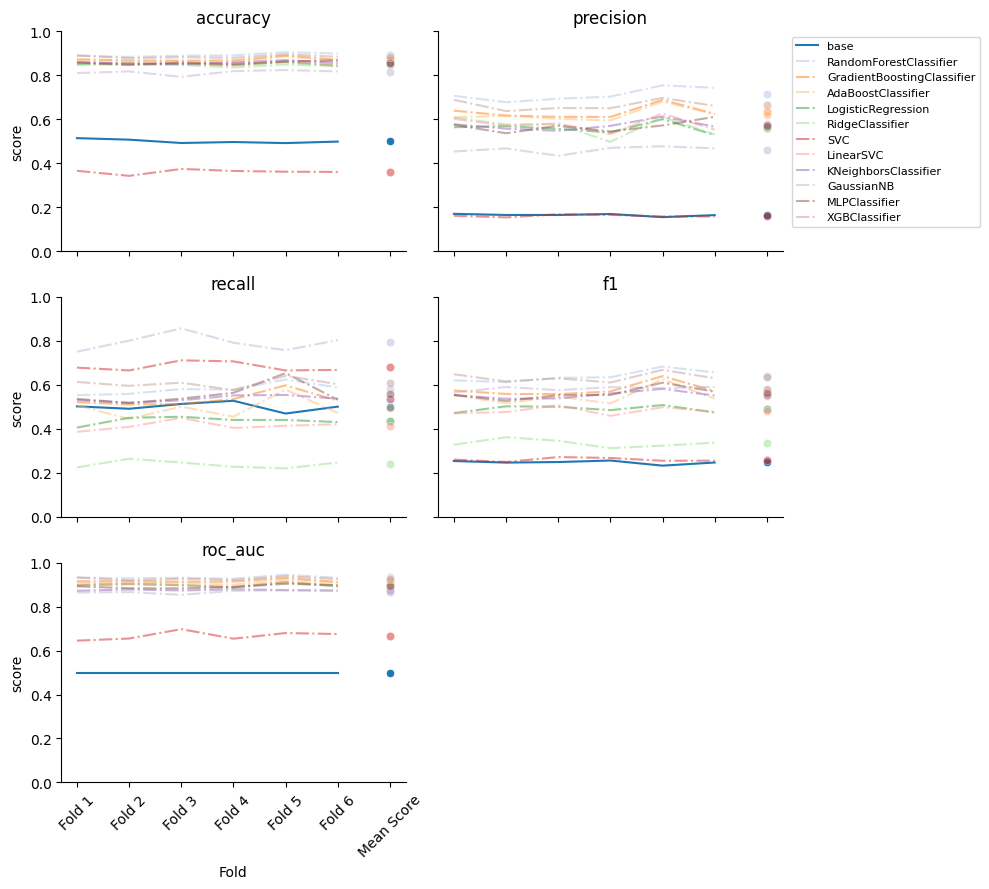

In [ ]:
plot_scoring(scoring, scores)

Science we predict whether client will be granted with a credit, we're more interested with high recall not high precision - after all, we'd prefer to guess that more people will be granted one than to discourage them from trying to.

In [ ]:
print_scores(scores, "f1")
print_scores(scores, "recall")

Models f1
	RandomForestClassifier        0.6401223317864978
	XGBClassifier                 0.6340540027889251
	GaussianNB                    0.5831107786032614
	GradientBoostingClassifier    0.5789501084486545
	MLPClassifier                 0.5615320289420698
	KNeighborsClassifier          0.5539355850935707
	AdaBoostClassifier            0.5492881373776033
	LogisticRegression            0.4906097470486324
	LinearSVC                     0.4818009944965956
	RidgeClassifier               0.3348761905954387
	SVC                           0.25996034517417105
Models recall
	GaussianNB                    0.7938857111664775
	SVC                           0.6829383599833121
	XGBClassifier                 0.6066934921024825
	RandomForestClassifier        0.580890581074811
	MLPClassifier                 0.5570878805956183
	KNeighborsClassifier          0.5373158188191348
	GradientBoostingClassifier    0.5344948591079762
	AdaBoostClassifier            0.49333848007392583
	LogisticRegression      

We'll try to fine-tune GaussianNB, XGBClassifier. Later we'll try some deep learning models, so we'll drop MLPClassifier for now. XGBClassifier in general is better option to RandomForestClassifier, so we'll drop it as well. Rest models are not that promising and it's not worth wasting computing resources for them.

# Fine tuning

In [9]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 1.0),
        "subsample": trial.suggest_loguniform("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.01, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 1.0),
        "eval_metric": "auc",
        "n_jobs": -1,
    }

    estimator = XGBClassifier(**params)
    cv_scores = cross_val_score(estimator, X_train, y_train, cv=5, scoring="roc_auc")
    return np.mean(cv_scores)


study = create_study(direction="maximize")
study.optimize(objective, n_trials=100)
print()

xgb_estimator = create_best_estimator(
    study,
    X_train,
    y_train,
    X_valid,
    y_valid,
    XGBClassifier,
)

[I 2024-03-30 21:33:48,935] A new study created in memory with name: no-name-a977937b-0d33-4b7f-8a27-33ae4aa22871
[I 2024-03-30 21:33:49,840] Trial 0 finished with value: 0.9096025787986883 and parameters: {'max_depth': 14, 'learning_rate': 0.04081968568086127, 'n_estimators': 199, 'min_child_weight': 5, 'gamma': 2.7207305727577146e-08, 'subsample': 0.02271301464058257, 'colsample_bytree': 0.2638854601956124, 'reg_alpha': 0.01873589186929171, 'reg_lambda': 0.00584373134680573}. Best is trial 0 with value: 0.9096025787986883.



Number of finished trials: 1
Best trial:
  Value: 0.9096025787986883
  Params: 
    max_depth: 14
    learning_rate: 0.04081968568086127
    n_estimators: 199
    min_child_weight: 5
    gamma: 2.7207305727577146e-08
    subsample: 0.02271301464058257
    colsample_bytree: 0.2638854601956124
    reg_alpha: 0.01873589186929171
    reg_lambda: 0.00584373134680573
Refitted best model f1-score: 0.8676970633693972


In [11]:
def objective(trial):
    params = {"var_smoothing": trial.suggest_loguniform("var_smoothing", 1e-9, 1.0)}

    estimator = GaussianNB(**params)
    cv_scores = cross_val_score(estimator, X_train, y_train, cv=5, scoring="roc_auc")
    return np.mean(cv_scores)


study = create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print()

xgb_estimator = create_best_estimator(
    study,
    X_train,
    y_train,
    X_valid,
    y_valid,
    GaussianNB,
)

[I 2024-03-30 21:39:10,528] A new study created in memory with name: no-name-fe4da87f-c0d9-42f3-a3d3-5f8ed2ac72e5
[I 2024-03-30 21:39:10,651] Trial 0 finished with value: 0.8821770938088411 and parameters: {'var_smoothing': 0.0023559585731712076}. Best is trial 0 with value: 0.8821770938088411.



Number of finished trials: 1
Best trial:
  Value: 0.8821770938088411
  Params: 
    var_smoothing: 0.0023559585731712076
Refitted best model f1-score: 0.8216383307573416
